Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Carpeta encontrada: /content/drive/MyDrive/dataset
Found 2056 images belonging to 13 classes.
Found 513 images belonging to 13 classes.
[INFO] Construyendo modelo avanzado...


/tmp/ipython-input-3790000569.py:68: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(weights="imagenet", include_top=False,


[INFO] Compilando e iniciando entrenamiento largo...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/90
64/64 ━━━━━━━━━━━━━━━━━━━━ 68s 826ms/step - accuracy: 0.1545 - loss: 2.5824 - val_accuracy: 0.1797 - val_loss: 2.3415
Epoch 2/90
 1/64 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4375 - loss: 1.8783

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - accuracy: 0.4375 - loss: 1.8783 - val_accuracy: 0.2168 - val_loss: 2.3210
Epoch 3/90
64/64 ━━━━━━━━━━━━━━━━━━━━ 39s 614ms/step - accuracy: 0.3525 - loss: 1.9442 - val_accuracy: 0.3281 - val_loss: 1.9947
Epoch 4/90
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.4062 - loss: 1.5081 - val_accuracy: 0.3242 - val_loss: 1.9682
Epoch 5/90
64/64 ━━━━━━━━━━━━━━━━━━━━ 39s 617ms/step - accuracy: 0.4756 - loss: 1.5852 - val_accuracy: 0.3691 - val_loss: 1.8794
Epoch 6/90
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - accuracy: 0.4375 - loss: 1.4987 - val_accuracy: 0.3516 - val_loss: 1.9000
Epoch 7/90
64/64 ━━━━━━━━━━━━━━━━━━━━ 39s 610ms/step - accuracy: 0.5204 - loss: 1.3784 - val_accuracy: 0.4238 - val_loss: 1.6976
Epoch 8/90
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.6562 - loss: 0.9764 - val_accuracy: 0.4121 - val_loss: 1.7269
Epoch 9/90
64/64 ━━━━━━━━━━━━━━━━━━━━ 39s 615ms/step - accuracy: 0.5926 - loss: 1.1709 - val_accuracy: 0.4668 - 

¡Modelo v2 Guardado!


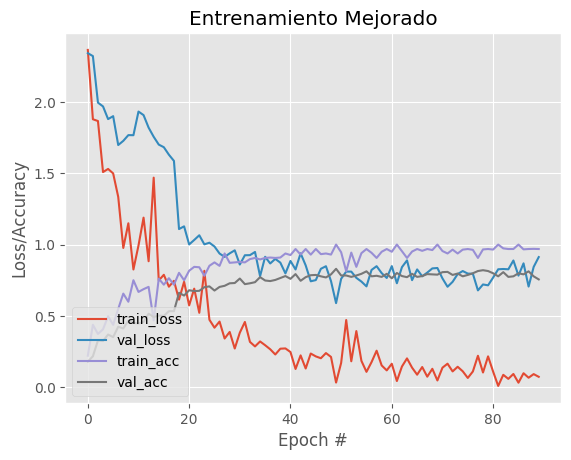

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# 1. Asegurar conexión con Drive
# Si ya está montado, esto no hará nada, si se cayó, lo reconecta.
try:
    drive.mount('/content/drive')
except:
    print("Drive ya estaba montado o hubo un error leve.")

# --- CONFIGURACIÓN AJUSTADA ---
# Verifica que esta ruta sea EXACTA (mayúsculas importan)
RUTA_DATASET = "/content/drive/MyDrive/dataset"
INIT_LR = 1e-4
EPOCHS = 90       # Aumentamos a 40 para llegar al 80%
BS = 32

# Verificar si la carpeta existe antes de empezar
if not os.path.exists(RUTA_DATASET):
    print(f"❌ ERROR CRÍTICO: No encuentro la carpeta en: {RUTA_DATASET}")
    print("Por favor, usa el panel de la izquierda para buscar tu carpeta, da click derecho y elige 'Copiar ruta'")
else:
    print(f"✅ Carpeta encontrada: {RUTA_DATASET}")

    # 2. Generadores
    aug = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest",
        preprocessing_function=preprocess_input,
        validation_split=0.2
    )

    train_generator = aug.flow_from_directory(
        RUTA_DATASET,
        target_size=(224, 224),
        batch_size=BS,
        class_mode="categorical",
        subset="training",
        shuffle=True
    )

    validation_generator = aug.flow_from_directory(
        RUTA_DATASET,
        target_size=(224, 224),
        batch_size=BS,
        class_mode="categorical",
        subset="validation"
    )

    labels = (train_generator.class_indices)
    labels = dict((v,k) for k,v in labels.items())

    # 3. Modelo con Fine Tuning
    print("[INFO] Construyendo modelo avanzado...")
    baseModel = MobileNetV2(weights="imagenet", include_top=False,
        input_tensor=Input(shape=(224, 224, 3)))

    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(len(labels), activation="softmax")(headModel)

    model = Model(inputs=baseModel.input, outputs=headModel)

    # --- EL TRUCO PRO: FINE TUNING ---
    # Primero congelamos todo
    for layer in baseModel.layers:
        layer.trainable = False

    # LUEGO descongelamos las últimas 20 capas para que la IA se vuelva experta en TUS fotos
    for layer in baseModel.layers[-20:]:
        layer.trainable = True

    # 4. Entrenar
    print("[INFO] Compilando e iniciando entrenamiento largo...")
    opt = Adam(learning_rate=INIT_LR) # Learning rate bajo para no romper lo descongelado
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

    H = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // BS,
        epochs=EPOCHS
    )

    # 5. Guardar
    model.save("mi_modelo_rostros_v2.h5") # Le puse v2 para diferenciar

    with open("etiquetas.txt", "w") as f:
        for i in range(len(labels)):
            f.write(labels[i] + "\n")

    print("¡Modelo v2 Guardado!")

    # 6. Graficar
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, EPOCHS), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, EPOCHS), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, EPOCHS), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, EPOCHS), H.history["val_accuracy"], label="val_acc")
    plt.title("Entrenamiento Mejorado")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig("grafico_final.png")
    plt.show()